In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import itertools
import lightgbm as lgbm
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

import matplotlib.pyplot as plt
import graphviz

from script import *
from feature_engineering import *
import db_operations as dbop
from constants import *
import data_process as dp

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
pd.set_option('display.max_rows',200)
idx = pd.IndexSlice
agg_operations =['mean','median','max','min','std','size']

In [3]:
%time df = pd.read_hdf(os.path.join('datasets','df_20140101.h5'),key='data')
df = df.sort_index()
df.shape
df.columns

Wall time: 4.53 s


(4593560, 64)

Index(['open', 'high', 'low', 'close', 'vol', 'amt', 'adj_factor', 'avg',
       'close0', 'avg0', 'pct', 'turnover_rate', 'turnover_rate_f',
       'volume_ratio', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'total_share',
       'float_share', 'free_share', 'total_mv', 'circ_mv', 'pb*pe_ttm',
       'pb*pe', '5ma', '10ma', '20ma', '40ma', '60ma', '120ma', '250ma',
       'close/5ma', 'close/10ma', 'close/20ma', 'close/40ma', 'close/60ma',
       'close/120ma', 'close/250ma', '60ma_pct', '20ma_pct', 'p5max_abs_pct',
       'p10max_abs_pct', '30ma', '30ma_pct', 'close/30ma', 'prev_close',
       'day_pct', 'close0_rank', 'close0_pct', 'prev_pct', 'prev_day_pct',
       'sell_at', 'sell_at0', 'sell_date', 'sell_idx', 'buy_at', 'buy_at0',
       'max', 'max_idx', 'idx', 'is_selled', 'r'],
      dtype='object')

In [25]:
eval_date_start = '2016-01-01'
mask_date = df.index.get_level_values('date')>='2016-01-01'


In [5]:
%time df['5ma_pct'] = df['5ma'].sort_index().groupby('code').pct_change()*100 # 7s

target_col = '5ma_pct'
min_periods=1

for k in [5,10,15,20,25,30]:
    %time tmp = groupby_rolling(df[[target_col]],level="code",window=k,ops=['mean','median','std'],min_periods=min_periods)
    df[tmp.columns] = tmp

for k in [5,10,15,20,25,30]:
#     %time tmp = groupby_rolling(df[[target_col,'close']],level="code",window=k,ops=['mean','median','std'],min_periods=min_periods)
#     df[tmp.columns] = tmp
    df['p{}mean-std_5ma_pct'.format(k)] = df['p{}mean_5ma_pct'.format(k)]-df['p{}std_5ma_pct'.format(k)]
    
list(df.columns)

Wall time: 6.02 s
Wall time: 11.6 s
Wall time: 9.69 s
Wall time: 9.71 s
Wall time: 10.5 s
Wall time: 10 s
Wall time: 11.7 s


['open',
 'high',
 'low',
 'close',
 'vol',
 'amt',
 'adj_factor',
 'avg',
 'close0',
 'avg0',
 'pct',
 'turnover_rate',
 'turnover_rate_f',
 'volume_ratio',
 'pe',
 'pe_ttm',
 'pb',
 'ps',
 'ps_ttm',
 'total_share',
 'float_share',
 'free_share',
 'total_mv',
 'circ_mv',
 'pb*pe_ttm',
 'pb*pe',
 '5ma',
 '10ma',
 '20ma',
 '40ma',
 '60ma',
 '120ma',
 '250ma',
 'close/5ma',
 'close/10ma',
 'close/20ma',
 'close/40ma',
 'close/60ma',
 'close/120ma',
 'close/250ma',
 '60ma_pct',
 '20ma_pct',
 'p5max_abs_pct',
 'p10max_abs_pct',
 '30ma',
 '30ma_pct',
 'close/30ma',
 'prev_close',
 'day_pct',
 'close0_rank',
 'close0_pct',
 'prev_pct',
 'prev_day_pct',
 'sell_at',
 'sell_at0',
 'sell_date',
 'sell_idx',
 'buy_at',
 'buy_at0',
 'max',
 'max_idx',
 'idx',
 'is_selled',
 'r',
 '5ma_pct',
 'p5mean_5ma_pct',
 'p5median_5ma_pct',
 'p5std_5ma_pct',
 'p10mean_5ma_pct',
 'p10median_5ma_pct',
 'p10std_5ma_pct',
 'p15mean_5ma_pct',
 'p15median_5ma_pct',
 'p15std_5ma_pct',
 'p20mean_5ma_pct',
 'p20media

In [6]:
%time df_tmp = df[mask_date] # 4s

quantiles = [0.5,0.8,0.9,0.95,0.99]
df_quantile = pd.DataFrame(columns=quantiles)

for k in [5,10,15,20,25,30]:
#     print('\nk={}'.format(k))
    for p in quantiles:
        col1 = 'p{}mean_5ma_pct'.format(k)
        col2 = 'p{}mean-std_5ma_pct'.format(k)
        df_quantile.loc[col1,p] = df[col1].quantile(p)
        df_quantile.loc[col2,p] = df[col2].quantile(p)
#         '{}:{:.1%}={:.3f}'.format(col1,p,df[col1].quantile(p))
#         '{}:{:.1%}={:.3f}'.format(col2,p,df[col2].quantile(p))

df_quantile

Wall time: 2.43 s


,0.50,0.80,0.90,0.95,0.99
p5mean_5ma_pct,0.0247288,0.749466,1.28705,1.90599,3.91871
p5mean-std_5ma_pct,-0.536927,0.132062,0.522473,0.938066,2.24703
p10mean_5ma_pct,0.0179279,0.611594,1.0413,1.51687,3.03925
p10mean-std_5ma_pct,-0.73381,-0.155048,0.113123,0.372153,1.09548
p15mean_5ma_pct,0.0135601,0.529096,0.895657,1.29339,2.51983
p15mean-std_5ma_pct,-0.840915,-0.303747,-0.0822442,0.113044,0.624762
p20mean_5ma_pct,0.00350311,0.471452,0.80449,1.1603,2.20205
p20mean-std_5ma_pct,-0.913115,-0.400348,-0.193278,-0.0348546,0.356693
p25mean_5ma_pct,-0.00207615,0.429371,0.735721,1.06207,1.97022
p25mean-std_5ma_pct,-0.961279,-0.470762,-0.275894,-0.132123,0.166346


In [7]:
%time date = df.index.get_level_values('date').drop_duplicates().sort_index()
len(date)
date_idx = pd.Series(np.arange(len(date)),index=date,name='date_idx')
date_idx.head()

Wall time: 227 ms


1561

date
2014-01-02    0
2014-01-03    1
2014-01-06    2
2014-01-07    3
2014-01-08    4
Name: date_idx, dtype: int32

In [8]:
%time df = df.join(date_idx,on='date',how='left') #5.84s
df.head()
df.columns

Wall time: 15.5 s


open        high         low       close  \
code      date                                                         
000001.SZ 2014-01-02  707.650452  718.160095  703.563354  714.072998   
          2014-01-03  709.402039  709.985901  687.798828  696.556946   
          2014-01-06  694.221436  700.644043  671.450500  681.376282   
          2014-01-07  673.202087  686.631165  672.034424  679.040833   
          2014-01-08  679.624695  697.724670  673.202087  686.631165   

                              vol       amt  adj_factor         avg  close0  \
code      date                                                                
000001.SZ 2014-01-02  8390.752930  5.962237   58.387001  710.572510   12.23   
          2014-01-03  9438.998047  6.566313   58.387001  695.657837   11.93   
          2014-01-06  9969.997070  6.792804   58.387001  681.324524   11.67   
          2014-01-07  5795.938965  3.939776   58.387001  679.747620   11.63   
          2014-01-08  7840.240723  5.384362   58.387001  686.759766   11.76   

                           avg0  ...  p30mean_5ma_pct  p30median_5ma_pct  \
code      date                   ...                                       
000001.SZ 2014-01-02  12.170046  ...              NaN                NaN   
          2014-01-03  11.914601  ...              NaN                NaN   
          2014-01-06  11.669113  ...              NaN                NaN   
          2014-01-07  11.642105  ...              NaN                NaN   
          2014-01-08  11.762203  ...              NaN                NaN   

                      p30std_5ma_pct  p5mean-std_5ma_pct  p10mean-std_5ma_pct  \
code      date                                                                  
000001.SZ 2014-01-02             NaN                 NaN                  NaN   
          2014-01-03             NaN                 NaN                  NaN   
          2014-01-06             NaN                 NaN                  NaN   
          2014-01-07             NaN                 NaN                  NaN   
          2014-01-08             NaN                 NaN                  NaN   

                      p15mean-std_5ma_pct  p20mean-std_5ma_pct  \
code      date                                                   
000001.SZ 2014-01-02                  NaN                  NaN   
          2014-01-03                  NaN                  NaN   
          2014-01-06                  NaN                  NaN   
          2014-01-07                  NaN                  NaN   
          2014-01-08                  NaN                  NaN   

                      p25mean-std_5ma_pct  p30mean-std_5ma_pct  date_idx  
code      date                                                            
000001.SZ 2014-01-02                  NaN                  NaN         0  
          2014-01-03                  NaN                  NaN         1  
          2014-01-06                  NaN                  NaN         2  
          2014-01-07                  NaN                  NaN         3  
          2014-01-08                  NaN                  NaN         4  

[5 rows x 90 columns]

Index(['open', 'high', 'low', 'close', 'vol', 'amt', 'adj_factor', 'avg',
       'close0', 'avg0', 'pct', 'turnover_rate', 'turnover_rate_f',
       'volume_ratio', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'total_share',
       'float_share', 'free_share', 'total_mv', 'circ_mv', 'pb*pe_ttm',
       'pb*pe', '5ma', '10ma', '20ma', '40ma', '60ma', '120ma', '250ma',
       'close/5ma', 'close/10ma', 'close/20ma', 'close/40ma', 'close/60ma',
       'close/120ma', 'close/250ma', '60ma_pct', '20ma_pct', 'p5max_abs_pct',
       'p10max_abs_pct', '30ma', '30ma_pct', 'close/30ma', 'prev_close',
       'day_pct', 'close0_rank', 'close0_pct', 'prev_pct', 'prev_day_pct',
       'sell_at', 'sell_at0', 'sell_date', 'sell_idx', 'buy_at', 'buy_at0',
       'max', 'max_idx', 'idx', 'is_selled', 'r', '5ma_pct', 'p5mean_5ma_pct',
       'p5median_5ma_pct', 'p5std_5ma_pct', 'p10mean_5ma_pct',
       'p10median_5ma_pct', 'p10std_5ma_pct', 'p15mean_5ma_pct',
       'p15median_5ma_pct', 'p15std_5ma_pct', 'p20me

In [9]:
df['f1_open'] = df['open'].sort_index().groupby('code').shift(-1)
df['f2_close'] = df['close'].sort_index().groupby('code').shift(-2)
df['f2_open'] = df['open'].sort_index().groupby('code').shift(-2)

%time df['r_t2'] = df['f2_close']/df['f1_open']-1
%time df['r_t1'] = df['f2_open']/df['f1_open']-1

df[['open','close','f1_open','f2_open','f2_close']].tail(5)

Wall time: 43 ms
Wall time: 31 ms


open      close    f1_open    f2_open   f2_close
code      date                                                             
688598.SH 2020-05-25  88.669998  78.300003  78.470001  82.040001  90.300003
          2020-05-26  78.470001  79.580002  82.040001  93.059998  92.360001
          2020-05-27  82.040001  90.300003  93.059998  88.000000  88.099998
          2020-05-28  93.059998  92.360001  88.000000        NaN        NaN
          2020-05-29  88.000000  88.099998        NaN        NaN        NaN

In [10]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r']

features = [col for col in df.columns 
            if col not in ['date_idx','r_t1','r_t2']+ ['f1_open','f2_close','f2_open','sell_at0','sell_idx','buy_at0']+r_columns 
            and is_numeric_dtype(df.dtypes[col])]

features

['open',
 'high',
 'low',
 'close',
 'vol',
 'amt',
 'adj_factor',
 'avg',
 'close0',
 'avg0',
 'pct',
 'turnover_rate',
 'turnover_rate_f',
 'volume_ratio',
 'pe',
 'pe_ttm',
 'pb',
 'ps',
 'ps_ttm',
 'total_share',
 'float_share',
 'free_share',
 'total_mv',
 'circ_mv',
 'pb*pe_ttm',
 'pb*pe',
 '5ma',
 '10ma',
 '20ma',
 '40ma',
 '60ma',
 '120ma',
 '250ma',
 'close/5ma',
 'close/10ma',
 'close/20ma',
 'close/40ma',
 'close/60ma',
 'close/120ma',
 'close/250ma',
 '60ma_pct',
 '20ma_pct',
 'p5max_abs_pct',
 'p10max_abs_pct',
 '30ma',
 '30ma_pct',
 'close/30ma',
 'prev_close',
 'day_pct',
 'close0_rank',
 'close0_pct',
 'prev_pct',
 'prev_day_pct',
 '5ma_pct',
 'p5mean_5ma_pct',
 'p5median_5ma_pct',
 'p5std_5ma_pct',
 'p10mean_5ma_pct',
 'p10median_5ma_pct',
 'p10std_5ma_pct',
 'p15mean_5ma_pct',
 'p15median_5ma_pct',
 'p15std_5ma_pct',
 'p20mean_5ma_pct',
 'p20median_5ma_pct',
 'p20std_5ma_pct',
 'p25mean_5ma_pct',
 'p25median_5ma_pct',
 'p25std_5ma_pct',
 'p30mean_5ma_pct',
 'p30median

In [141]:
mask_trend = [
    df['p15mean-std_5ma_pct'] > 0.15,
]

mask_low_pos = [

    df['close/60ma']<1.2,
#     df['close/60ma']<1.125,

#     df['close/30ma']<1.05, 
    df['close/5ma']<1.1,
    df['close/10ma']<1.1,
#     df['close/60ma']<1.25,

    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic

# for m in masks:
for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

df_sample = df[mask_final]
df_sample.shape

(199754, 4593560, 0.0435, 0.0435)

(3556357, 4593560, 0.7742, 0.0208)

(4473030, 4593560, 0.9738, 0.0208)

(4301818, 4593560, 0.9365, 0.0203)

(4110067, 4593560, 0.8947, 0.0203)

(1056950, 4593560, 0.2301, 0.0055)

(4348257, 4593560, 0.9466, 0.0049)

(2056374, 4593560, 0.4477, 0.0043)

(1433930, 4593560, 0.3122, 0.0034)

(4580262, 4593560, 0.9971, 0.0034)

(3453794, 4593560, 0.7519, 0.0025)

(11475, 95)

In [143]:
mask_y = df_sample[['r_t1','r_t2']].notnull().all(axis=1)
X,Y = df_sample.loc[mask_y,features].fillna(-9999),df_sample.loc[mask_y,['r_t1','r_t2']]
X.shape,Y.shape
Y.agg(agg_operations)

((11462, 78), (11462, 2))

,r_t1,r_t2
mean,0.001417,0.003397
median,-0.000499,0.000000
max,0.229508,0.232816
min,-0.191725,-0.189483
std,0.030150,0.038342
size,11462.000000,11462.000000


DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=3.5e-06,
           min_impurity_split=None, min_samples_leaf=50,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

pct            0.881003
close/120ma    0.118997
dtype: float64

2

pred  pred_rank  pred_rank_pct
code      date                                          
000001.SZ 2017-09-07  0.007257        1.0       0.294118
          2017-09-08  0.000658        3.0       0.615385
          2017-11-27  0.007257        2.0       0.500000
          2017-11-28  0.007257        1.0       0.250000
          2019-01-24  0.000658        3.0       0.578947

r_t1                                          r_t2            \
              mean    median       max       min  size      mean    median   
pred                                                                         
0.000658 -0.000672 -0.002400  0.165109 -0.137728  7952  0.000658 -0.002449   
0.002526  0.010794  0.008696  0.127209 -0.133858    53  0.002526  0.001649   
0.007257  0.003583  0.002132  0.175556 -0.191725  3160  0.007257  0.003033   
0.035828  0.032610  0.034078  0.229508 -0.088617   297  0.035828  0.034868   

                                    pred_rank                           \
               max       min  size       mean median    max  min  size   
pred                                                                     
0.000658  0.205608 -0.166402  7952   8.549673    4.0  153.0  1.0  7952   
0.002526  0.151590 -0.111958    53  18.773585    8.0  152.0  1.0    53   
0.007257  0.185841 -0.189483  3160   3.412658    1.0   88.0  1.0  3160   
0.035828  0.232816 -0.088617   297   1.000000    1.0    1.0  1.0   297   

         pred_rank_pct                                 
                  mean    median  max       min  size  
pred                                                   
0.000658      0.645231  0.622642  1.0  0.507353  7952  
0.002526      0.615476  0.666667  1.0  0.153846    53  
0.007257      0.303267  0.277778  1.0  0.009479  3160  
0.035828      0.216097  0.253623  1.0  0.010870   297

<BarContainer object of 4 artists>

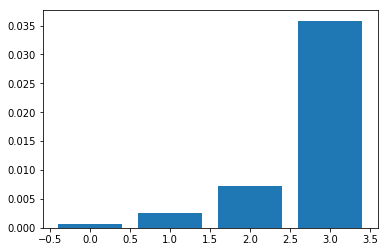

<BarContainer object of 4 artists>

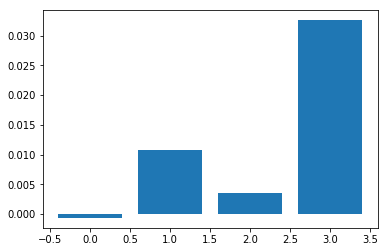

In [144]:
reg = DecisionTreeRegressor(max_depth=2,min_samples_leaf=50,random_state=0,
#                             min_samples_split=500,
                            min_impurity_decrease=3.5e-6,
                           )
# reg = lgbm.LGBMRegressor(max_depth=10,min_child_samples=5,random_state=0,n_estimators=1,learning_rate=1,importance_type ='gain')

reg.fit(X[['pct','close/120ma']],Y['r_t2'])
importance = pd.Series(reg.feature_importances_,index=['pct','close/120ma']).sort_values(ascending=False)
importance[importance>0]
(importance>0).sum()
# reg.predict(X)

y_pred = pd.DataFrame(reg.predict(X[['pct','close/120ma']]),index=Y.index,columns=['pred'])
y_pred['pred_rank'] = y_pred.groupby('date')['pred'].rank(ascending=False,method='min')
y_pred['pred_rank_pct'] = y_pred.groupby('date')['pred'].rank(ascending=False,pct=True)
y_pred.head()
Y2 = Y.join(y_pred,how='left')
res = Y2.groupby('pred').agg(['mean','median','max','min','size']).sort_index()
res
plt.bar(np.arange(len(res)),res[('r_t2','mean')])
plt.show()
plt.bar(np.arange(len(res)),res[('r_t1','mean')])

# reg.predict(X)

(113, 6)

r_t1                     r_t2               
                mean    median size      mean    median size
date                                                        
2016-01-04  0.086088  0.086088    2  0.093477  0.093477    2
2016-02-05  0.074830  0.074830    1  0.095238  0.095238    1
2016-02-25  0.052837  0.052837    2  0.088135  0.088135    2
2016-02-29  0.021153  0.006272    4  0.089219  0.068031    4
2016-03-04 -0.002739 -0.002739    2  0.008147  0.008147    2

,r_t1_mean,r_t1_median,r_t1_size,r_t2_mean,r_t2_median,r_t2_size,idx,r_t2_mean_0,r_t2_median_0,r_t2_mean_1,r_t2_median_1
date,,,,,,,,,,,
2020-05-25,0.026804,0.026804,1.0,-0.004124,-0.004124,1.0,1067,-0.004124,-0.004124,0.0,0.0
2020-05-26,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1068,0.000000,0.000000,0.0,0.0
2020-05-27,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1069,0.000000,0.000000,0.0,0.0
2020-05-28,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1070,0.000000,0.000000,0.0,0.0
2020-05-29,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1071,0.000000,0.000000,0.0,0.0


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1
date,,,,,,
2016-01-04,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-05,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-06,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-07,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-08,1.086088,1.086088,1.0,1.0,1.093477,1.093477


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5,1,'val_r_t1_mean withdraw')

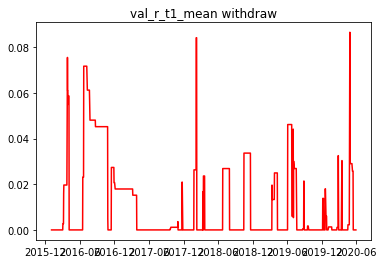

Text(0.5,1,'val_r_t1_median withdraw')

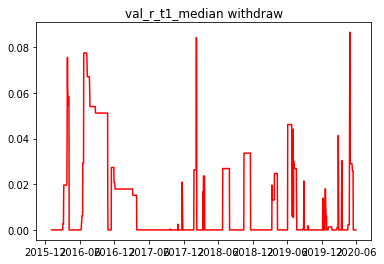

Text(0.5,1,'val_r_t2_mean_0 withdraw')

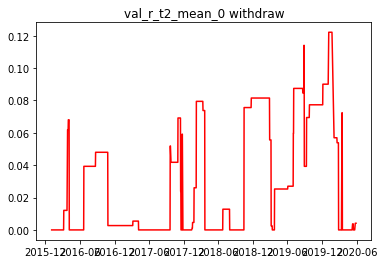

Text(0.5,1,'val_r_t2_median_0 withdraw')

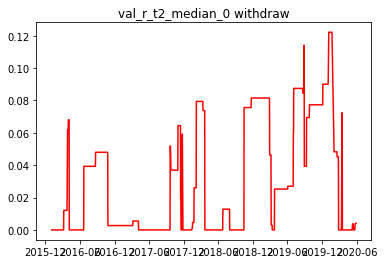

Text(0.5,1,'val_r_t2_mean_1 withdraw')

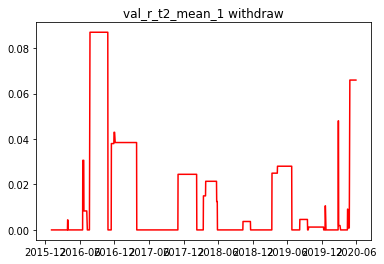

Text(0.5,1,'val_r_t2_median_1 withdraw')

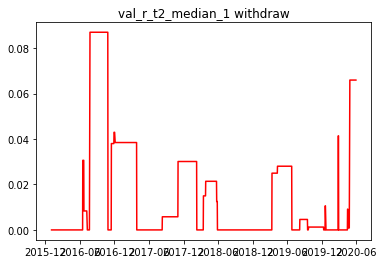

Text(0.5,1,'val_r_t2_mean withdraw')

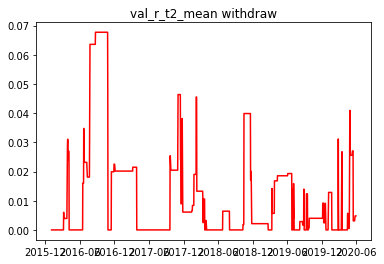

Text(0.5,1,'val_r_t2_median withdraw')

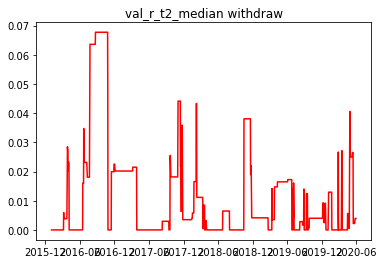

,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,...,cummax_val_r_t2_median_0,withdraw_val_r_t2_median_0,cummax_val_r_t2_mean_1,withdraw_val_r_t2_mean_1,cummax_val_r_t2_median_1,withdraw_val_r_t2_median_1,cummax_val_r_t2_mean,withdraw_val_r_t2_mean,cummax_val_r_t2_median,withdraw_val_r_t2_median
date,,,,,,,,,,,,,,,,,,,,,
2020-04-30,NaN,NaN,NaN,NaN,NaN,NaN,6.653271,6.571902,2.034511,2.080136,...,2.080136,0.000000,3.205516,0.065952,3.202807,0.065952,2.580326,0.025585,2.600894,0.025006
2020-05-06,NaN,NaN,NaN,NaN,NaN,NaN,6.653271,6.571902,2.034511,2.080136,...,2.080136,0.000000,3.205516,0.065952,3.202807,0.065952,2.580326,0.025585,2.600894,0.025006
2020-05-07,NaN,NaN,NaN,NaN,NaN,NaN,6.653271,6.571902,2.034511,2.080136,...,2.080136,0.000000,3.205516,0.065952,3.202807,0.065952,2.580326,0.025585,2.600894,0.025006
2020-05-08,NaN,NaN,NaN,NaN,NaN,NaN,6.653271,6.571902,2.034511,2.080136,...,2.080136,0.000000,3.205516,0.065952,3.202807,0.065952,2.580326,0.025585,2.600894,0.025006
2020-05-11,0.003424,0.003424,1.0,-0.003735,-0.003735,1.0,6.676049,6.594401,2.026912,2.072367,...,2.080136,0.003735,3.205516,0.065952,3.202807,0.065952,2.580326,0.027057,2.600894,0.026500
2020-05-12,NaN,NaN,NaN,NaN,NaN,NaN,6.676049,6.594401,2.026912,2.072367,...,2.080136,0.003735,3.205516,0.065952,3.202807,0.065952,2.580326,0.027057,2.600894,0.026500
2020-05-13,NaN,NaN,NaN,NaN,NaN,NaN,6.676049,6.594401,2.026912,2.072367,...,2.080136,0.003735,3.205516,0.065952,3.202807,0.065952,2.580326,0.027057,2.600894,0.026500
2020-05-14,NaN,NaN,NaN,NaN,NaN,NaN,6.676049,6.594401,2.026912,2.072367,...,2.080136,0.003735,3.205516,0.065952,3.202807,0.065952,2.580326,0.027057,2.600894,0.026500
2020-05-15,0.034078,0.034078,1.0,0.061011,0.061011,1.0,6.903558,6.819128,2.150577,2.198805,...,2.198805,0.000000,3.205516,0.065952,3.202807,0.065952,2.580326,0.003094,2.600894,0.002193


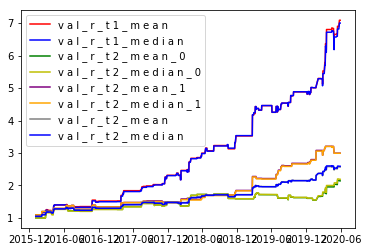


--------------------
M


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.035287,0.035135,0.013797,0.014035,0.020329,0.020295,0.016915,0.017008
median,0.003009,0.003009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.063714,0.064633,0.052928,0.052647,0.049906,0.049509,0.037026,0.036822


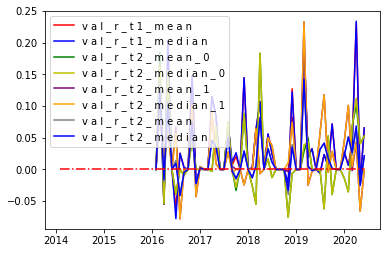


--------------------
Q


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,0.092018,0.076465,0.120896,0.099092,0.110677,0.118083,0.115558,0.109011


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.110252,0.109324,0.042966,0.044426,0.060041,0.060036,0.051209,0.051777
median,0.096578,0.100331,0.043417,0.046054,0.057930,0.057930,0.040529,0.040367
std,0.080712,0.077636,0.070185,0.073367,0.074283,0.074965,0.055641,0.057122


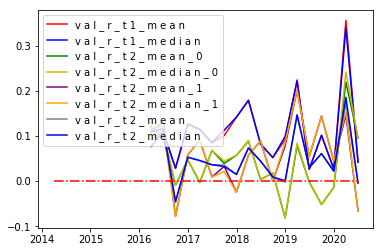


--------------------
A


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-31,0.399550,0.379057,0.266182,0.259185,0.225804,0.222221,0.245092,0.239878
2017-12-31,0.521185,0.537497,0.170325,0.176264,0.109416,0.097335,0.139003,0.135624
2018-12-31,0.524875,0.534804,0.073566,0.073566,0.241752,0.250207,0.157806,0.161450
2019-12-31,0.422178,0.419673,0.007710,0.012014,0.514661,0.514661,0.280040,0.281206
2020-12-31,0.413635,0.395449,0.335960,0.360763,0.070514,0.077219,0.167228,0.181242


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.456284,0.453296,0.170749,0.176358,0.232429,0.232329,0.197834,0.199880
median,0.422178,0.419673,0.170325,0.176264,0.225804,0.222221,0.167228,0.181242
std,0.061477,0.077009,0.134563,0.140036,0.174022,0.174940,0.061219,0.059512


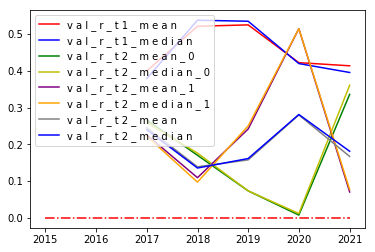

In [145]:
tmp_day = Y2[(Y2['pred']>0.01)].groupby('date')[['r_t1','r_t2']].agg(['mean','median','size'])
tmp_day.shape
tmp_day.head()



day_r = tmp_day.reindex(date[date>eval_date_start]).fillna(0)

day_r.columns = ['_'.join(col) for col in day_r]
day_r['idx'] = np.arange(len(day_r))
day_r_t2_0=day_r[['r_t2_mean','r_t2_median']].add_suffix('_0')
day_r_t2_0.loc[day_r['idx']%2==0,:]=0

day_r_t2_1=day_r[['r_t2_mean','r_t2_median']].add_suffix('_1')
day_r_t2_1.loc[day_r['idx']%2==1,:]=0
# day_r.tail(50)
# day_r_t2_0.tail(50)
# day_r_t2_1.tail(50)

day_r = pd.concat([day_r,day_r_t2_0,day_r_t2_1],axis=1)
day_r.tail(5)


day_v = (day_r[['r_t1_mean','r_t1_median','r_t2_mean_0','r_t2_median_0','r_t2_mean_1','r_t2_median_1']]+1).cumprod().add_prefix('val_')
day_v.head()
day_v['val_r_t2_mean'] = (day_v['val_r_t2_mean_0']+day_v['val_r_t2_mean_1'])/2
day_v['val_r_t2_median'] = (day_v['val_r_t2_median_0']+day_v['val_r_t2_median_1'])/2
result_day = tmp_day.reindex(date).join(day_v,how='left')
result_day.head()
for col in day_v.columns:
    result_day['cummax_{}'.format(col)] = result_day[col].expanding().max() 
    result_day['withdraw_{}'.format(col)] = 1-result_day[col]/result_day['cummax_{}'.format(col)]
    plt.plot(result_day.index,result_day['withdraw_{}'.format(col)],color='r')
    plt.title('{} withdraw'.format(col))
    plt.show()

result_day.tail(20)


f= plt.figure()
for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
    _ = plt.plot(day_v.index,day_v[col],color=c,label=' '.join(col))
_ = plt.legend(loc='upper left')
plt.show()
# f.savefig('val_curve.png')



result_dict = {'day':result_day}

for key,p in zip(['month','quarter','year'],['M','Q','A']):
    result_period = result_day[day_v.columns].resample(p).apply(lambda x:x[-1]/x[0]-1)
    print('\n'+'-'*20+'\n'+p)
    result_dict[key] = result_period
    result_dict[key+'_stats'] = result_period.agg(['mean','median','std'])
    result_dict[key]
    result_dict[key+'_stats']
    
    for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
        _ = plt.plot(result_period.index,result_period[col],color=c,label=' '.join(col))
    _ = plt.legend(loc='upper left')
    _ = plt.plot(result_period.index,[0]*len(result_period),color='r',linestyle='-.')
    plt.show()

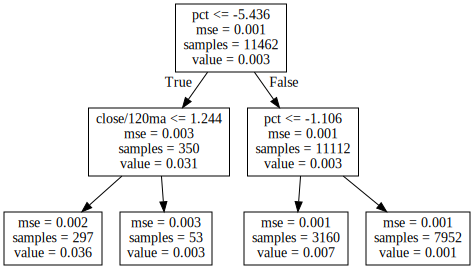

In [152]:
graph = tree.export_graphviz(reg, out_file=None, feature_names=['pct','close/120ma'])
# print(graph)
# graph
graphviz.Source(graph,format='png')
import pickle
with open('reg.pkl',mode='wb') as f:
    pickle.dump(reg,f)

In [48]:


with pd.ExcelWriter("result.xlsx") as writer:
    Y2[(Y2['pred']>0.01)].to_excel(writer,sheet_name='signal_0.01')
    for k in sorted(result_dict.keys()):
        result_dict[k].to_excel(writer,sheet_name=k)



In [278]:
mask_trend = [
    df['p15mean-std_5ma_pct'] > 0.3,
]

mask_low_pos = [
#     df['pct'].fillna(-9999)<=-5,
#     df['close/120ma'].fillna(-9999)<=1.25,
    df['close/60ma']<1.2,
#     df['close/60ma']<1.125,

#     df['close/30ma']<1.05, 
    df['close/5ma']<1.02,
    df['close/10ma']<1.02,

    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic

# for m in masks:
for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

df_sample = df[mask_final]
df_sample.shape

(121436, 4593560, 0.0264, 0.0264)

(3556357, 4593560, 0.7742, 0.0098)

(3581283, 4593560, 0.7796, 0.0068)

(3144629, 4593560, 0.6846, 0.0026)

(4110067, 4593560, 0.8947, 0.0026)

(1056950, 4593560, 0.2301, 0.0007)

(4348257, 4593560, 0.9466, 0.0006)

(2056374, 4593560, 0.4477, 0.0006)

(1433930, 4593560, 0.3122, 0.0004)

(4580262, 4593560, 0.9971, 0.0004)

(3453794, 4593560, 0.7519, 0.0003)

(1423, 95)

In [154]:
# Y2.shape
# df_sample.shape
df_sample.reindex(Y2.index).loc[Y2['pred']>0.01,['pct','close/120ma']].agg(['max','min','size'])
df_sample.loc[df_sample['r_t2'].notnull(),features].fillna(-9999).shape
pred_tmp = pd.Series(reg.predict(df_sample.loc[df_sample['r_t2'].notnull(),features].fillna(-9999)),index=df_sample.index[df_sample['r_t2'].notnull()])
pred_tmp[pred_tmp>0.01]

,pct,close/120ma
max,-5.439007,1.243578
min,-10.073709,0.699274
size,297.000000,297.000000


(383, 78)

ValueError: Number of features of the model must match the input. Model n_features is 2 and input n_features is 78 

(496, 6)

r_t1                     r_t2               
                mean    median size      mean    median size
date                                                        
2016-02-05  0.042376  0.042376    2  0.080805  0.080805    2
2016-02-15  0.025206  0.025206    2  0.071142  0.071142    2
2016-02-25  0.045987  0.045987    1  0.090301  0.090301    1
2016-02-29 -0.002013 -0.004124    3  0.064542  0.061062    3
2016-03-01  0.058608  0.058608    2  0.090629  0.090629    2

,r_t1_mean,r_t1_median,r_t1_size,r_t2_mean,r_t2_median,r_t2_size,idx,r_t2_mean_0,r_t2_median_0,r_t2_mean_1,r_t2_median_1
date,,,,,,,,,,,
2020-05-25,0.040365,0.026804,5.0,0.032330,0.001965,5.0,1067,0.03233,0.001965,0.000000,0.000000
2020-05-26,-0.041371,-0.041371,1.0,-0.014208,-0.014208,1.0,1068,0.00000,0.000000,-0.014208,-0.014208
2020-05-27,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1069,0.00000,0.000000,0.000000,0.000000
2020-05-28,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1070,0.00000,0.000000,0.000000,0.000000
2020-05-29,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1071,0.00000,0.000000,0.000000,0.000000


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1
date,,,,,,
2016-01-04,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-05,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-06,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-07,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-08,1.0,1.0,1.0,1.0,1.0,1.0


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5,1,'val_r_t1_mean withdraw')

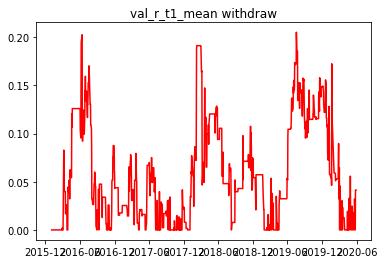

Text(0.5,1,'val_r_t1_median withdraw')

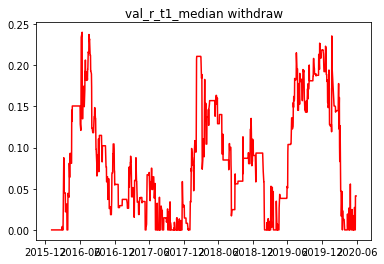

Text(0.5,1,'val_r_t2_mean_0 withdraw')

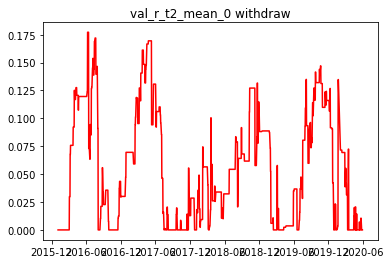

Text(0.5,1,'val_r_t2_median_0 withdraw')

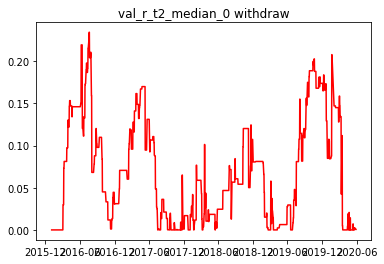

Text(0.5,1,'val_r_t2_mean_1 withdraw')

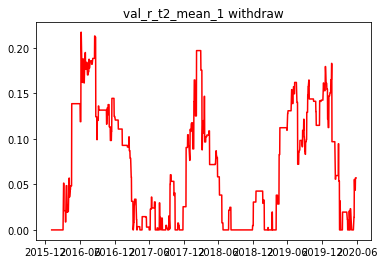

Text(0.5,1,'val_r_t2_median_1 withdraw')

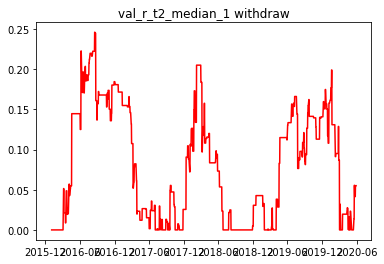

Text(0.5,1,'val_r_t2_mean withdraw')

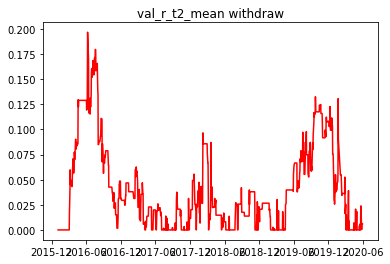

Text(0.5,1,'val_r_t2_median withdraw')

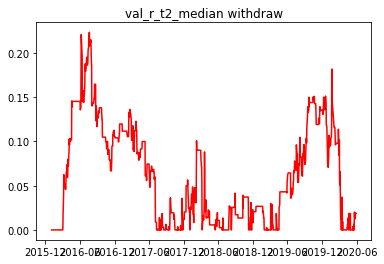

,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,...,cummax_val_r_t2_median_0,withdraw_val_r_t2_median_0,cummax_val_r_t2_mean_1,withdraw_val_r_t2_mean_1,cummax_val_r_t2_median_1,withdraw_val_r_t2_median_1,cummax_val_r_t2_mean,withdraw_val_r_t2_mean,cummax_val_r_t2_median,withdraw_val_r_t2_median
date,,,,,,,,,,,,,,,,,,,,,
2020-04-30,0.038689,0.038689,1.0,0.048761,0.048761,1.0,5.556647,3.801449,5.304290,3.951175,...,3.951175,0.000000,4.112675,0.023311,3.405965,0.023311,4.660548,0.000000,3.638872,0.000000
2020-05-06,0.023023,0.023023,1.0,0.041515,0.041515,1.0,5.684576,3.888968,5.304290,3.951175,...,3.951175,0.000000,4.183564,0.000000,3.464672,0.000000,4.743927,0.000000,3.707924,0.000000
2020-05-07,NaN,NaN,NaN,NaN,NaN,NaN,5.684576,3.888968,5.304290,3.951175,...,3.951175,0.000000,4.183564,0.000000,3.464672,0.000000,4.743927,0.000000,3.707924,0.000000
2020-05-08,-0.024800,-0.024800,1.0,0.012000,0.012000,1.0,5.543598,3.792522,5.304290,3.951175,...,3.951175,0.000000,4.233767,0.000000,3.506248,0.000000,4.769028,0.000000,3.728712,0.000000
2020-05-11,0.017897,0.017897,2.0,0.009711,0.009711,2.0,5.642812,3.860397,5.355801,3.989546,...,3.989546,0.000000,4.233767,0.000000,3.506248,0.000000,4.794784,0.000000,3.747897,0.000000
2020-05-12,NaN,NaN,NaN,NaN,NaN,NaN,5.642812,3.860397,5.355801,3.989546,...,3.989546,0.000000,4.233767,0.000000,3.506248,0.000000,4.794784,0.000000,3.747897,0.000000
2020-05-13,0.007519,0.007519,1.0,-0.007101,-0.007101,1.0,5.685239,3.889422,5.317769,3.961216,...,3.989546,0.007101,4.233767,0.000000,3.506248,0.000000,4.794784,0.003966,3.747897,0.003779
2020-05-14,-0.018228,-0.017413,3.0,0.001086,0.012949,3.0,5.581608,3.821696,5.317769,3.961216,...,3.989546,0.007101,4.238365,0.000000,3.551652,0.000000,4.794784,0.003486,3.756434,0.000000
2020-05-15,0.001355,0.034078,3.0,0.021713,0.061011,3.0,5.589168,3.951933,5.433232,4.202895,...,4.202895,0.000000,4.238365,0.000000,3.551652,0.000000,4.835798,0.000000,3.877274,0.000000


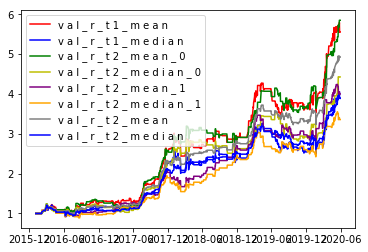


--------------------
M


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.030353,0.023785,0.033322,0.028987,0.023890,0.020735,0.028115,0.024246
median,0.000000,-0.000809,0.014345,0.006841,0.015052,0.011179,0.010412,0.009917
std,0.085876,0.084907,0.096227,0.098833,0.071037,0.071259,0.071166,0.073420


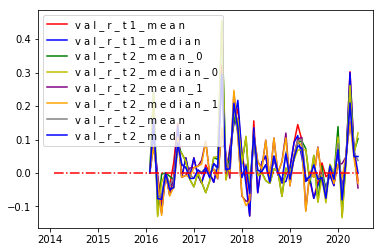


--------------------
Q


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,0.171148,0.162470,0.087719,0.077936,0.154813,0.154813,0.121266,0.116374


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.110829,0.089415,0.114305,0.097764,0.085971,0.075159,0.098670,0.084606
median,0.034249,0.030249,0.090638,0.089817,0.068967,0.067219,0.064390,0.058762
std,0.184087,0.180096,0.173397,0.168516,0.137160,0.132562,0.134957,0.131860


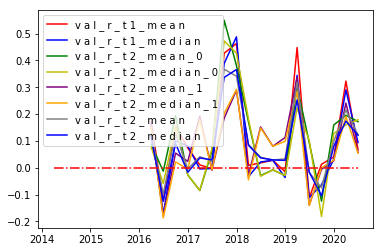


--------------------
A


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-31,0.311958,0.179101,0.260736,0.151752,0.048083,-0.023343,0.154409,0.064204
2017-12-31,1.079057,1.022093,1.104463,1.063277,0.804990,0.818525,0.968518,0.950968
2018-12-31,0.040506,-0.021534,0.096288,0.103705,0.345974,0.301956,0.201278,0.189349
2019-12-31,0.351792,0.151721,0.434386,0.233782,0.174863,0.135521,0.312114,0.187314
2020-12-31,0.411967,0.411991,0.401653,0.367666,0.312584,0.256030,0.364079,0.317176


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.439056,0.348674,0.459505,0.384036,0.337299,0.297738,0.400080,0.341802
median,0.351792,0.179101,0.401653,0.233782,0.312584,0.256030,0.312114,0.189349
std,0.385015,0.406848,0.384508,0.392669,0.286990,0.317169,0.328646,0.352086


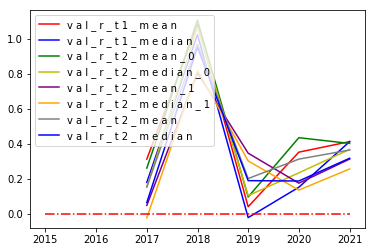

In [279]:
tmp_day = df_sample.groupby('date')[['r_t1','r_t2']].agg(['mean','median','size'])
tmp_day.shape
tmp_day.head()



day_r = tmp_day.reindex(date[date>eval_date_start]).fillna(0)

day_r.columns = ['_'.join(col) for col in day_r]
day_r['idx'] = np.arange(len(day_r))
day_r_t2_0=day_r[['r_t2_mean','r_t2_median']].add_suffix('_0')
day_r_t2_0.loc[day_r['idx']%2==0,:]=0

day_r_t2_1=day_r[['r_t2_mean','r_t2_median']].add_suffix('_1')
day_r_t2_1.loc[day_r['idx']%2==1,:]=0
# day_r.tail(50)
# day_r_t2_0.tail(50)
# day_r_t2_1.tail(50)

day_r = pd.concat([day_r,day_r_t2_0,day_r_t2_1],axis=1)
day_r.tail(5)


day_v = (day_r[['r_t1_mean','r_t1_median','r_t2_mean_0','r_t2_median_0','r_t2_mean_1','r_t2_median_1']]+1).cumprod().add_prefix('val_')
day_v.head()
day_v['val_r_t2_mean'] = (day_v['val_r_t2_mean_0']+day_v['val_r_t2_mean_1'])/2
day_v['val_r_t2_median'] = (day_v['val_r_t2_median_0']+day_v['val_r_t2_median_1'])/2
result_day = tmp_day.reindex(date).join(day_v,how='left')
result_day.head()
for col in day_v.columns:
    result_day['cummax_{}'.format(col)] = result_day[col].expanding().max() 
    result_day['withdraw_{}'.format(col)] = 1-result_day[col]/result_day['cummax_{}'.format(col)]
    plt.plot(result_day.index,result_day['withdraw_{}'.format(col)],color='r')
    plt.title('{} withdraw'.format(col))
    plt.show()

result_day.tail(20)


f= plt.figure()
for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
    _ = plt.plot(day_v.index,day_v[col],color=c,label=' '.join(col))
_ = plt.legend(loc='upper left')
plt.show()
# f.savefig('val_curve.png')



result_dict = {'day':result_day}

for key,p in zip(['month','quarter','year'],['M','Q','A']):
    result_period = result_day[day_v.columns].resample(p).apply(lambda x:x[-1]/x[0]-1)
    print('\n'+'-'*20+'\n'+p)
    result_dict[key] = result_period
    result_dict[key+'_stats'] = result_period.agg(['mean','median','std'])
    result_dict[key]
    result_dict[key+'_stats']
    
    for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
        _ = plt.plot(result_period.index,result_period[col],color=c,label=' '.join(col))
    _ = plt.legend(loc='upper left')
    _ = plt.plot(result_period.index,[0]*len(result_period),color='r',linestyle='-.')
    plt.show()

In [75]:
# df_sample[['pct','close/120ma']].agg(['max','min'])
df_sample.index.difference(Y2.index)

MultiIndex([('000735.SZ', '2020-05-28'),
            ('000735.SZ', '2020-05-29'),
            ('002511.SZ', '2020-05-28'),
            ('002511.SZ', '2020-05-29'),
            ('300699.SZ', '2020-05-28'),
            ('300725.SZ', '2020-05-28'),
            ('300725.SZ', '2020-05-29'),
            ('600037.SH', '2020-05-26'),
            ('600057.SH', '2020-05-28'),
            ('600515.SH', '2020-05-28'),
            ('600515.SH', '2020-05-29'),
            ('603195.SH', '2020-05-28'),
            ('603195.SH', '2020-05-29')],
           names=['code', 'date'])

In [156]:
sample_weight = pd.Series(1,index=X_train.index)
mask_weight = df_sample.loc[mask_train,'date_idx']>train_end_idx-125
sample_weight.loc[mask_weight]+= (df_sample.loc[mask_train,'date_idx']-train_end_idx+125)/125*4

sample_weight.head(20)

NameError: name 'X_train' is not defined

In [281]:
mask_trend = [
    df['p15mean-std_5ma_pct'] > 0.3,
]

mask_low_pos = [
#     df['pct'].fillna(-9999)<=-5,
#     df['close/120ma'].fillna(-9999)<=1.25,
    df['close/60ma']<1.2,
#     df['close/60ma']<1.125,

#     df['close/30ma']<1.05, 
    df['close/5ma']<1.05,
    df['close/10ma']<1.05,

    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic

for m in masks:
# for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

df_sample = df[mask_final]
df_sample.shape

(121436, 4593560, 0.0264, 0.0264)

(3556357, 4593560, 0.7742, 0.0098)

(4260136, 4593560, 0.9274, 0.0093)

(3918805, 4593560, 0.8531, 0.0069)

(4110067, 4593560, 0.8947, 0.0069)

(1056950, 4593560, 0.2301, 0.0018)

(4348257, 4593560, 0.9466, 0.0016)

(2056374, 4593560, 0.4477, 0.0014)

(1433930, 4593560, 0.3122, 0.0011)

(4580262, 4593560, 0.9971, 0.0011)

(5167, 95)

In [286]:
train_end_idx = 250 *2-1
train_period = 10

ycols = ['r_t1','r_t2']
ycol = 'r_t2'

cnt=0
y_pred_list = []
while train_end_idx+2<=date_idx.max():
    
    mask_train_date = df_sample['date_idx']<=train_end_idx
    mask_y = df_sample[ycol].notnull()
    mask_train = mask_train_date & mask_y
    
    mask_test = (df_sample['date_idx']>=train_end_idx+2) & (df_sample['date_idx']<train_end_idx+12)
    
    X_train,y_train = df_sample.loc[mask_train,features].fillna(-9999),df_sample.loc[mask_train,ycol]
    X_test,y_test = df_sample.loc[mask_test,features].fillna(-9999),df_sample.loc[mask_test,ycol]
    
#     X_train,y_train = df_sample.loc[mask_train,features],df_sample.loc[mask_train,ycol]
#     X_test,y_test = df_sample.loc[mask_test,features],df_sample.loc[mask_test,ycol]
    
    sample_weight = pd.Series(1,index=X_train.index)
    mask_weight = df_sample.loc[mask_train,'date_idx']>train_end_idx-125
    sample_weight.loc[mask_weight]+= (df_sample.loc[mask_train,'date_idx']-train_end_idx+125)/125*4
    
    if len(X_test)==0 or len(X_train)==0:
        print(train_end_idx,X_train.shape,y_train.shape,X_test.shape,y_test.shape)
        train_end_idx+=train_period
#         cnt +=1
        continue

    
        

    reg = DecisionTreeRegressor(max_depth=10,min_samples_leaf=50, #max(50,len(X_train)//200),
                                min_weight_fraction_leaf = 0.005,
#                                 min_samples_split = 200,
                                max_leaf_nodes=12,
                                min_impurity_decrease=3.5e-6,
                                random_state=0)
#     reg = lgbm.LGBMRegressor(num_leaves=8, max_depth= 6, learning_rate=0.4, n_estimators=10, subsample_for_bin=200000, 
#                              objective=None, 
#                              min_split_gain=0.0, min_child_weight=75, min_child_samples=50, 
#                              subsample=0.6, subsample_freq=1, colsample_bytree=0.6, 
#                              reg_alpha=0.0, reg_lambda=0.0, random_state=0, n_jobs=- 1, silent=True, importance_type='gain',)
    _ = reg.fit(X_train,y_train,sample_weight=sample_weight.values)
#     pd.DataFrame(reg.predict(X_test),index = X_test.index,columns=['pred'])
    y_pred_list.append(pd.DataFrame(reg.predict(X_test),index = X_test.index,columns=['pred']))
    
    if cnt%10==0:
        print(train_end_idx,X_train.shape,y_train.shape,X_test.shape,y_test.shape)
        importance = pd.Series(reg.feature_importances_,index=features).sort_values(ascending=False)
        importance[importance>0].head()
    
    train_end_idx+=train_period
    cnt +=1
#     break
    

499 (1375, 78) (1375,) (0, 78) (0,)
509 (1375, 78) (1375,) (7, 78) (7,)


pct                0.528628
close/120ma        0.151805
pe_ttm             0.064703
close/20ma         0.061143
turnover_rate_f    0.045462
dtype: float64

569 (1534, 78) (1534,) (0, 78) (0,)
619 (1749, 78) (1749,) (38, 78) (38,)


pct                  0.411794
close/10ma           0.103715
close/250ma          0.102540
p20median_5ma_pct    0.066231
pe                   0.064870
dtype: float64

719 (1938, 78) (1938,) (11, 78) (11,)


pct             0.399586
60ma_pct        0.158264
close/120ma     0.094225
5ma_pct         0.083250
prev_day_pct    0.073225
dtype: float64

819 (2115, 78) (2115,) (12, 78) (12,)


pct            0.453053
60ma_pct       0.123709
close/120ma    0.122708
close/5ma      0.068608
close/10ma     0.049163
dtype: float64

919 (2457, 78) (2457,) (44, 78) (44,)


pct                0.344804
turnover_rate_f    0.117583
close/20ma         0.111214
p30std_5ma_pct     0.090115
close/250ma        0.070454
dtype: float64

1019 (2817, 78) (2817,) (196, 78) (196,)


pct              0.292216
total_mv         0.111006
p5std_5ma_pct    0.087979
day_pct          0.081213
60ma_pct         0.080856
dtype: float64

1119 (3163, 78) (3163,) (6, 78) (6,)


pct                0.392103
close/120ma        0.137845
close/5ma          0.095693
60ma_pct           0.083806
turnover_rate_f    0.060032
dtype: float64

1169 (3191, 78) (3191,) (0, 78) (0,)
1209 (3231, 78) (3231,) (0, 78) (0,)
1239 (3270, 78) (3270,) (97, 78) (97,)


pct            0.420276
close/120ma    0.126168
close/20ma     0.091994
close/5ma      0.069073
60ma_pct       0.050223
dtype: float64

1299 (4041, 78) (4041,) (0, 78) (0,)
1349 (4201, 78) (4201,) (26, 78) (26,)


pct             0.346614
volume_ratio    0.129478
5ma_pct         0.127963
close/60ma      0.071861
avg0            0.069266
dtype: float64

1449 (4570, 78) (4570,) (113, 78) (113,)


pct             0.411442
close/5ma       0.097274
prev_day_pct    0.074317
close/120ma     0.070406
volume_ratio    0.065061
dtype: float64

1549 (5121, 78) (5121,) (41, 78) (41,)


pct                0.415776
p20mean_5ma_pct    0.094403
close/5ma          0.091439
close/40ma         0.078125
60ma_pct           0.075364
dtype: float64

In [287]:
y_pred = pd.concat(y_pred_list,axis=0)
y_pred['pred_rank'] = y_pred.groupby('date')['pred'].rank(ascending=False,method='min')
y_pred['pred_rank_pct'] = y_pred.groupby('date')['pred'].rank(ascending=False,pct=True)
y_pred.shape
y_pred.head()

Y = df.loc[mask_final&mask_date,ycols]


Y2 = Y.join(y_pred,how='left')
# res = Y2.groupby('pred').agg(['mean','median','max','min','size']).sort_index()
# res
# plt.bar(np.arange(len(res)),res[('r_t2','mean')])
# plt.show()
# plt.bar(np.arange(len(res)),res[('r_t1','mean')])


(3792, 3)

pred  pred_rank  pred_rank_pct
code      date                                          
002416.SZ 2016-02-05 -0.030393        1.0           0.75
          2016-02-15 -0.026064        2.0           1.00
          2016-02-16 -0.026064        1.0           1.00
002640.SZ 2016-02-19  0.005894        1.0           1.00
300294.SZ 2016-02-05 -0.030393        1.0           0.75

In [288]:
signal_mask = (Y2['pred']>0.005) & (Y2['pred_rank']<=1)
signal_mask.sum()
tmp_day = Y2[signal_mask].groupby('date')[['r_t1','r_t2']].agg(['mean','median','size'])
tmp_day.shape
tmp_day.head()



day_r = tmp_day.reindex(date[date>=eval_date_start]).fillna(0)

day_r.columns = ['_'.join(col) for col in day_r]
day_r['idx'] = np.arange(len(day_r))
day_r_t2_0=day_r[['r_t2_mean','r_t2_median']].add_suffix('_0')
day_r_t2_0.loc[day_r['idx']%2==0,:]=0

day_r_t2_1=day_r[['r_t2_mean','r_t2_median']].add_suffix('_1')
day_r_t2_1.loc[day_r['idx']%2==1,:]=0
# day_r.tail(50)
# day_r_t2_0.tail(50)
# day_r_t2_1.tail(50)

day_r = pd.concat([day_r,day_r_t2_0,day_r_t2_1],axis=1)
day_r.tail(5)

750

(476, 6)

r_t1                     r_t2               
                mean    median size      mean    median size
date                                                        
2016-02-15  0.043450  0.043450    1  0.021397  0.021397    1
2016-02-19 -0.011765 -0.011765    1  0.008235  0.008235    1
2016-02-23  0.010666  0.010666    1 -0.085751 -0.085751    1
2016-02-25  0.045987  0.045987    1  0.090301  0.090301    1
2016-02-29 -0.004124 -0.004124    1  0.057438  0.057438    1

,r_t1_mean,r_t1_median,r_t1_size,r_t2_mean,r_t2_median,r_t2_size,idx,r_t2_mean_0,r_t2_median_0,r_t2_mean_1,r_t2_median_1
date,,,,,,,,,,,
2020-05-25,0.026804,0.026804,1.0,-0.004124,-0.004124,1.0,1067,-0.004124,-0.004124,0.000000,0.000000
2020-05-26,-0.041371,-0.041371,1.0,-0.014208,-0.014208,1.0,1068,0.000000,0.000000,-0.014208,-0.014208
2020-05-27,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1069,0.000000,0.000000,0.000000,0.000000
2020-05-28,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1070,0.000000,0.000000,0.000000,0.000000
2020-05-29,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1071,0.000000,0.000000,0.000000,0.000000


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1
date,,,,,,
2016-01-04,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-05,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-06,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-07,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-08,1.0,1.0,1.0,1.0,1.0,1.0


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5,1,'val_r_t1_mean withdraw')

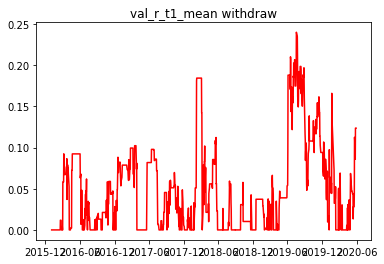

Text(0.5,1,'val_r_t1_median withdraw')

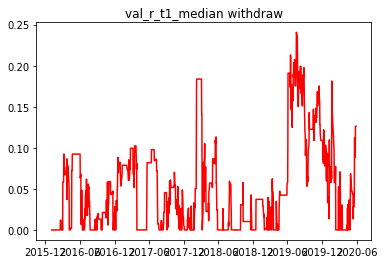

Text(0.5,1,'val_r_t2_mean_0 withdraw')

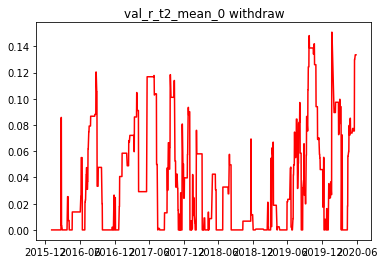

Text(0.5,1,'val_r_t2_median_0 withdraw')

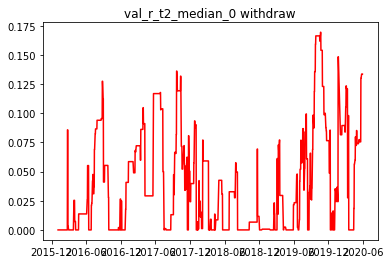

Text(0.5,1,'val_r_t2_mean_1 withdraw')

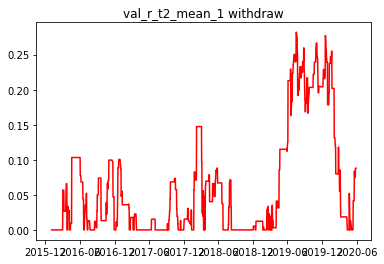

Text(0.5,1,'val_r_t2_median_1 withdraw')

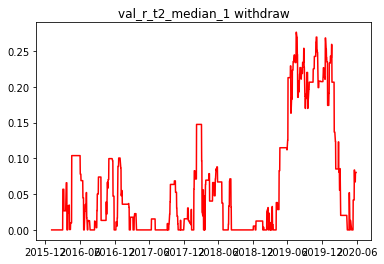

Text(0.5,1,'val_r_t2_mean withdraw')

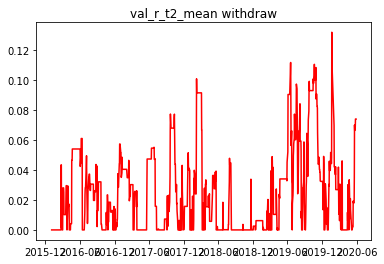

Text(0.5,1,'val_r_t2_median withdraw')

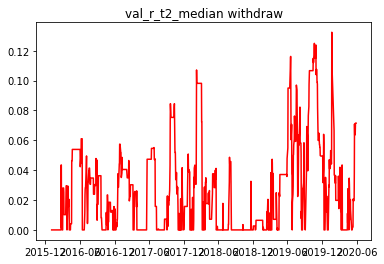

,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,...,cummax_val_r_t2_median_0,withdraw_val_r_t2_median_0,cummax_val_r_t2_mean_1,withdraw_val_r_t2_mean_1,cummax_val_r_t2_median_1,withdraw_val_r_t2_median_1,cummax_val_r_t2_mean,withdraw_val_r_t2_mean,cummax_val_r_t2_median,withdraw_val_r_t2_median
date,,,,,,,,,,,,,,,,,,,,,
2020-04-30,-0.001409,-0.001409,1.0,0.012311,0.012311,1.0,8.015600,7.535904,6.961759,5.778768,...,6.239885,0.073898,4.714724,0.013212,4.566943,0.013212,5.888044,0.013748,5.213728,0.013626
2020-05-06,0.023023,0.023023,1.0,0.041515,0.041515,1.0,8.200141,7.709401,6.961759,5.778768,...,6.239885,0.073898,4.845578,0.000000,4.693696,0.000000,5.903668,0.000000,5.236232,0.000000
2020-05-07,NaN,NaN,NaN,NaN,NaN,NaN,8.200141,7.709401,6.961759,5.778768,...,6.239885,0.073898,4.845578,0.000000,4.693696,0.000000,5.903668,0.000000,5.236232,0.000000
2020-05-08,NaN,NaN,NaN,NaN,NaN,NaN,8.200141,7.709401,6.961759,5.778768,...,6.239885,0.073898,4.845578,0.000000,4.693696,0.000000,5.903668,0.000000,5.236232,0.000000
2020-05-11,0.003424,0.003424,1.0,-0.003735,-0.003735,1.0,8.228214,7.735795,6.935758,5.757185,...,6.239885,0.077357,4.845578,0.000000,4.693696,0.000000,5.903668,0.002202,5.236232,0.002061
2020-05-12,NaN,NaN,NaN,NaN,NaN,NaN,8.228214,7.735795,6.935758,5.757185,...,6.239885,0.077357,4.845578,0.000000,4.693696,0.000000,5.903668,0.002202,5.236232,0.002061
2020-05-13,NaN,NaN,NaN,NaN,NaN,NaN,8.228214,7.735795,6.935758,5.757185,...,6.239885,0.077357,4.845578,0.000000,4.693696,0.000000,5.903668,0.002202,5.236232,0.002061
2020-05-14,0.031867,0.031867,1.0,-0.041730,-0.041730,1.0,8.490419,7.982308,6.935758,5.757185,...,6.239885,0.077357,4.845578,0.041730,4.693696,0.041730,5.903668,0.019328,5.236232,0.020764
2020-05-15,-0.015007,-0.015007,2.0,0.002063,0.002063,2.0,8.363001,7.862514,6.950069,5.769065,...,6.239885,0.075453,4.845578,0.041730,4.693696,0.041730,5.903668,0.018115,5.236232,0.019630


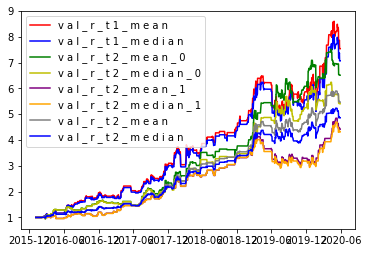


--------------------
M


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.038862,0.037795,0.036941,0.033625,0.028308,0.028210,0.031810,0.029764
median,0.021144,0.021144,0.019629,0.015725,0.030767,0.030767,0.013438,0.019691
std,0.088831,0.088839,0.094424,0.093759,0.076321,0.077213,0.069252,0.067758


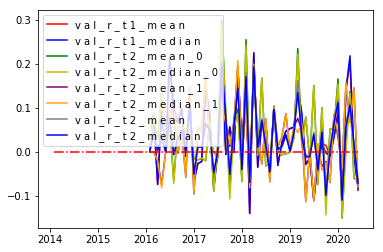


--------------------
Q


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,0.057994,0.057994,0.114439,0.114439,0.039448,0.039448,0.076944,0.076944


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.125699,0.121491,0.118747,0.106908,0.092198,0.090657,0.103003,0.095368
median,0.106204,0.102031,0.097509,0.097510,0.083085,0.084940,0.078712,0.076995
std,0.138451,0.136399,0.151518,0.146784,0.126116,0.124657,0.106606,0.100126


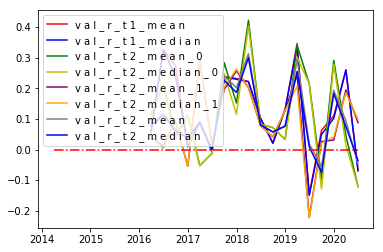


--------------------
A


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-31,0.816543,0.768113,0.600433,0.587719,0.084983,0.077736,0.342708,0.332727
2017-12-31,0.650584,0.646106,0.381652,0.300111,0.970909,0.990270,0.621933,0.581750
2018-12-31,0.554311,0.553963,0.704351,0.681689,0.522046,0.522047,0.613869,0.599587
2019-12-31,0.351587,0.308816,0.881715,0.747645,0.025076,-0.002899,0.480736,0.380360
2020-12-31,0.175104,0.172127,-0.081542,-0.108807,0.299863,0.301392,0.042050,0.036193


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.509626,0.489825,0.497322,0.441671,0.380575,0.377709,0.420259,0.386123
median,0.554311,0.553963,0.600433,0.587719,0.299863,0.301392,0.480736,0.380360
std,0.251468,0.244784,0.370714,0.352003,0.383659,0.398978,0.240245,0.228677


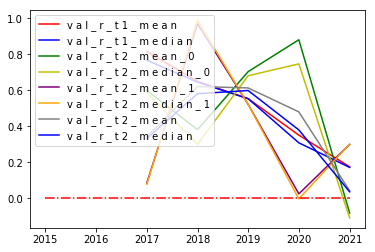

In [289]:
day_v = (day_r[['r_t1_mean','r_t1_median','r_t2_mean_0','r_t2_median_0','r_t2_mean_1','r_t2_median_1']]+1).cumprod().add_prefix('val_')
day_v.head()
day_v['val_r_t2_mean'] = (day_v['val_r_t2_mean_0']+day_v['val_r_t2_mean_1'])/2
day_v['val_r_t2_median'] = (day_v['val_r_t2_median_0']+day_v['val_r_t2_median_1'])/2
result_day = tmp_day.reindex(date).join(day_v,how='left')
result_day.head()
for col in day_v.columns:
    result_day['cummax_{}'.format(col)] = result_day[col].expanding().max() 
    result_day['withdraw_{}'.format(col)] = 1-result_day[col]/result_day['cummax_{}'.format(col)]
    plt.plot(result_day.index,result_day['withdraw_{}'.format(col)],color='r')
    plt.title('{} withdraw'.format(col))
    plt.show()

result_day.tail(20)


f= plt.figure()
for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
    _ = plt.plot(day_v.index,day_v[col],color=c,label=' '.join(col))
_ = plt.legend(loc='upper left')
plt.show()
# f.savefig('val_curve.png')



result_dict = {'day':result_day}

for key,p in zip(['month','quarter','year'],['M','Q','A']):
    result_period = result_day[day_v.columns].resample(p).apply(lambda x:x[-1]/x[0]-1)
    print('\n'+'-'*20+'\n'+p)
    result_dict[key] = result_period
    result_dict[key+'_stats'] = result_period.agg(['mean','median','std'])
    result_dict[key]
    result_dict[key+'_stats']
    
    for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
        _ = plt.plot(result_period.index,result_period[col],color=c,label=' '.join(col))
    _ = plt.legend(loc='upper left')
    _ = plt.plot(result_period.index,[0]*len(result_period),color='r',linestyle='-.')
    plt.show()

In [302]:
train_end_idx = 250 *2-1
train_period = 10

ycols = ['r_t1','r_t2']
ycol = 'r_t2'

cnt=0
y_pred_list = []
while train_end_idx+2<=date_idx.max():
    
    mask_train_date = df_sample['date_idx']<=train_end_idx
    mask_y = df_sample[ycol].notnull()
    mask_train = mask_train_date & mask_y
    
    mask_test = (df_sample['date_idx']>=train_end_idx+2) & (df_sample['date_idx']<train_end_idx+12)
    
    X_train,y_train = df_sample.loc[mask_train,features].fillna(-9999),df_sample.loc[mask_train,ycol]
    X_test,y_test = df_sample.loc[mask_test,features].fillna(-9999),df_sample.loc[mask_test,ycol]
    
#     X_train,y_train = df_sample.loc[mask_train,features],df_sample.loc[mask_train,ycol]
#     X_test,y_test = df_sample.loc[mask_test,features],df_sample.loc[mask_test,ycol]
    
    sample_weight = pd.Series(1,index=X_train.index)
    mask_weight = df_sample.loc[mask_train,'date_idx']>train_end_idx-125
    sample_weight.loc[mask_weight]+= (df_sample.loc[mask_train,'date_idx']-train_end_idx+125)/125*4
    
    if len(X_test)==0 or len(X_train)==0:
        print(train_end_idx,X_train.shape,y_train.shape,X_test.shape,y_test.shape)
        train_end_idx+=train_period
#         cnt +=1
        continue

    
        

#     reg = DecisionTreeRegressor(max_depth=10,min_samples_leaf=50, #max(50,len(X_train)//200),
#                                 min_weight_fraction_leaf = 0.005,
# #                                 min_samples_split = 200,
#                                 max_leaf_nodes=12,
#                                 min_impurity_decrease=3.5e-6,
#                                 random_state=0)
    reg = lgbm.LGBMRegressor(num_leaves=8, max_depth= 6, learning_rate=0.2, n_estimators=10, subsample_for_bin=200000, 
                             objective=None, 
                             min_split_gain=0.0, min_child_weight=75, min_child_samples=50, 
                             subsample=0.6, subsample_freq=1, colsample_bytree=0.6, 
                             reg_alpha=0.0, reg_lambda=0.0, random_state=0, n_jobs=- 1, silent=True, importance_type='gain',)
    _ = reg.fit(X_train,y_train,sample_weight=sample_weight.values)
#     pd.DataFrame(reg.predict(X_test),index = X_test.index,columns=['pred'])
    y_pred_list.append(pd.DataFrame(reg.predict(X_test),index = X_test.index,columns=['pred']))
    
    if cnt%10==0:
        print(train_end_idx,X_train.shape,y_train.shape,X_test.shape,y_test.shape)
        importance = pd.Series(reg.feature_importances_,index=features).sort_values(ascending=False)
        importance[importance>0].head()
    
    train_end_idx+=train_period
    cnt +=1
#     break
    

499 (1375, 78) (1375,) (0, 78) (0,)
509 (1375, 78) (1375,) (7, 78) (7,)


pct               5
day_pct           4
p30std_5ma_pct    3
volume_ratio      3
ps                3
dtype: int32

569 (1534, 78) (1534,) (0, 78) (0,)
619 (1749, 78) (1749,) (38, 78) (38,)


day_pct      4
close/5ma    3
amt          3
pct          3
60ma_pct     3
dtype: int32

719 (1938, 78) (1938,) (11, 78) (11,)


close/5ma              7
p30mean-std_5ma_pct    4
p30mean_5ma_pct        4
volume_ratio           4
p10max_abs_pct         3
dtype: int32

819 (2115, 78) (2115,) (12, 78) (12,)


close/120ma      4
pct              4
close/5ma        4
p5std_5ma_pct    3
amt              3
dtype: int32

919 (2457, 78) (2457,) (44, 78) (44,)


amt           4
close0        4
120ma         4
close/20ma    4
60ma_pct      4
dtype: int32

1019 (2817, 78) (2817,) (196, 78) (196,)


close/5ma         4
p10max_abs_pct    4
day_pct           4
60ma_pct          3
adj_factor        2
dtype: int32

1119 (3163, 78) (3163,) (6, 78) (6,)


close/5ma              6
p30mean_5ma_pct        6
p30mean-std_5ma_pct    3
p30std_5ma_pct         3
volume_ratio           3
dtype: int32

1169 (3191, 78) (3191,) (0, 78) (0,)
1209 (3231, 78) (3231,) (0, 78) (0,)
1239 (3270, 78) (3270,) (97, 78) (97,)


pct                  5
day_pct              5
close/5ma            4
p25median_5ma_pct    4
close/120ma          3
dtype: int32

1299 (4041, 78) (4041,) (0, 78) (0,)
1349 (4201, 78) (4201,) (26, 78) (26,)


pct                6
60ma_pct           4
p30mean_5ma_pct    4
volume_ratio       4
prev_pct           3
dtype: int32

1449 (4570, 78) (4570,) (113, 78) (113,)


pct                    7
close/5ma              5
p20mean-std_5ma_pct    3
day_pct                3
p30std_5ma_pct         3
dtype: int32

1549 (5121, 78) (5121,) (41, 78) (41,)


pct             5
close/5ma       5
day_pct         4
5ma_pct         3
volume_ratio    3
dtype: int32

In [305]:
y_pred = pd.concat(y_pred_list,axis=0)
y_pred['pred_rank'] = y_pred.groupby('date')['pred'].rank(ascending=False,method='min')
y_pred['pred_rank_pct'] = y_pred.groupby('date')['pred'].rank(ascending=False,pct=True)
y_pred.shape
y_pred.head()

Y = df.loc[mask_final&mask_date,ycols]


Y2 = Y.join(y_pred,how='left')
# res = Y2.groupby('pred').agg(['mean','median','max','min','size']).sort_index()
# res
# plt.bar(np.arange(len(res)),res[('r_t2','mean')])
# plt.show()
# plt.bar(np.arange(len(res)),res[('r_t1','mean')])


signal_mask = (Y2['pred']>0.01) & (Y2['pred_rank']<=1)
signal_mask.sum()
tmp_day = Y2[signal_mask].groupby('date')[['r_t1','r_t2']].agg(['mean','median','size'])
tmp_day.shape
tmp_day.head()



day_r = tmp_day.reindex(date[date>=eval_date_start]).fillna(0)

day_r.columns = ['_'.join(col) for col in day_r]
day_r['idx'] = np.arange(len(day_r))
day_r_t2_0=day_r[['r_t2_mean','r_t2_median']].add_suffix('_0')
day_r_t2_0.loc[day_r['idx']%2==0,:]=0

day_r_t2_1=day_r[['r_t2_mean','r_t2_median']].add_suffix('_1')
day_r_t2_1.loc[day_r['idx']%2==1,:]=0
# day_r.tail(50)
# day_r_t2_0.tail(50)
# day_r_t2_1.tail(50)

day_r = pd.concat([day_r,day_r_t2_0,day_r_t2_1],axis=1)
day_r.tail(5)

(3792, 3)

pred  pred_rank  pred_rank_pct
code      date                                          
002416.SZ 2016-02-05 -0.004807        1.0            0.5
          2016-02-15 -0.002940        2.0            1.0
          2016-02-16 -0.012212        1.0            1.0
002640.SZ 2016-02-19  0.003986        1.0            1.0
300294.SZ 2016-02-05 -0.009338        2.0            1.0

404

(403, 6)

r_t1                     r_t2               
                mean    median size      mean    median size
date                                                        
2016-02-25  0.045987  0.045987    1  0.090301  0.090301    1
2016-02-29 -0.004124 -0.004124    1  0.057438  0.057438    1
2016-03-01  0.052351  0.052351    1  0.066844  0.066844    1
2016-03-07 -0.076205 -0.076205    1 -0.051840 -0.051840    1
2016-03-08 -0.036220 -0.036220    1  0.005828  0.005828    1

,r_t1_mean,r_t1_median,r_t1_size,r_t2_mean,r_t2_median,r_t2_size,idx,r_t2_mean_0,r_t2_median_0,r_t2_mean_1,r_t2_median_1
date,,,,,,,,,,,
2020-05-25,0.026804,0.026804,1.0,-0.004124,-0.004124,1.0,1067,-0.004124,-0.004124,0.0,0.0
2020-05-26,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1068,0.000000,0.000000,0.0,0.0
2020-05-27,0.005355,0.005355,1.0,0.067650,0.067650,1.0,1069,0.067650,0.067650,0.0,0.0
2020-05-28,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1070,0.000000,0.000000,0.0,0.0
2020-05-29,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1071,0.000000,0.000000,0.0,0.0


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1
date,,,,,,
2016-01-04,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-05,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-06,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-07,1.0,1.0,1.0,1.0,1.0,1.0
2016-01-08,1.0,1.0,1.0,1.0,1.0,1.0


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5,1,'val_r_t1_mean withdraw')

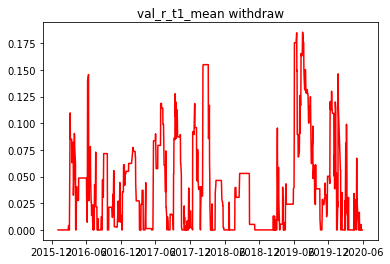

Text(0.5,1,'val_r_t1_median withdraw')

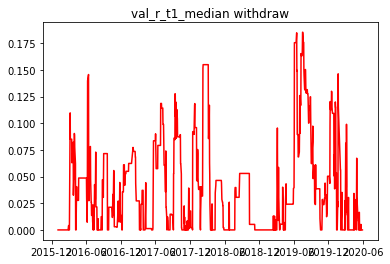

Text(0.5,1,'val_r_t2_mean_0 withdraw')

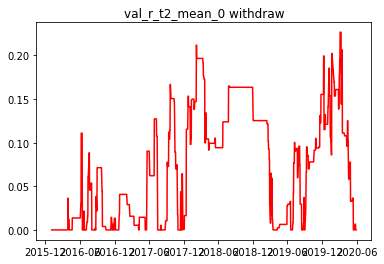

Text(0.5,1,'val_r_t2_median_0 withdraw')

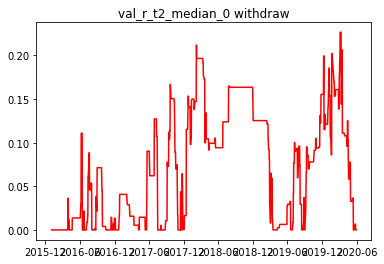

Text(0.5,1,'val_r_t2_mean_1 withdraw')

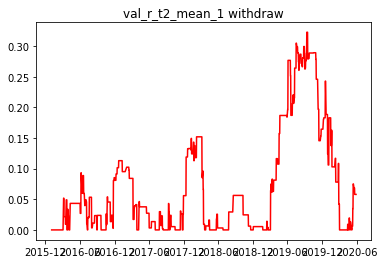

Text(0.5,1,'val_r_t2_median_1 withdraw')

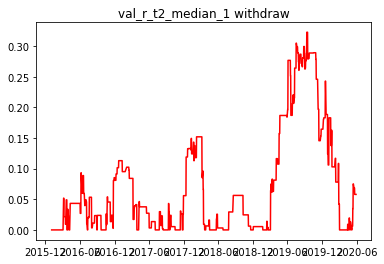

Text(0.5,1,'val_r_t2_mean withdraw')

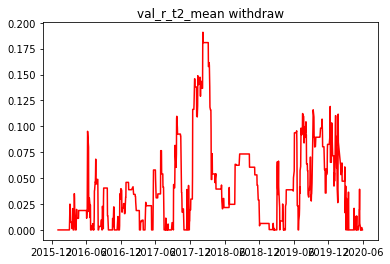

Text(0.5,1,'val_r_t2_median withdraw')

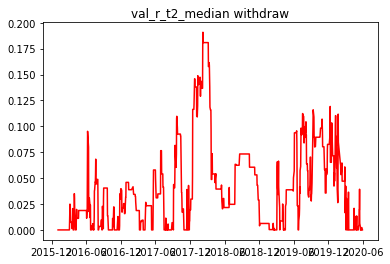

,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,...,cummax_val_r_t2_median_0,withdraw_val_r_t2_median_0,cummax_val_r_t2_mean_1,withdraw_val_r_t2_mean_1,cummax_val_r_t2_median_1,withdraw_val_r_t2_median_1,cummax_val_r_t2_mean,withdraw_val_r_t2_mean,cummax_val_r_t2_median,withdraw_val_r_t2_median
date,,,,,,,,,,,,,,,,,,,,,
2020-04-30,0.038689,0.038689,1.0,0.048761,0.048761,1.0,8.326674,8.326674,4.028951,4.028951,...,4.165738,0.032836,3.89202,0.013212,3.89202,0.013212,3.934774,0.000000,3.934774,0.000000
2020-05-06,0.023023,0.023023,1.0,0.041515,0.041515,1.0,8.518375,8.518375,4.028951,4.028951,...,4.165738,0.032836,4.00004,0.000000,4.00004,0.000000,4.014496,0.000000,4.014496,0.000000
2020-05-07,NaN,NaN,NaN,NaN,NaN,NaN,8.518375,8.518375,4.028951,4.028951,...,4.165738,0.032836,4.00004,0.000000,4.00004,0.000000,4.014496,0.000000,4.014496,0.000000
2020-05-08,0.014670,0.014670,1.0,-0.006112,-0.006112,1.0,8.643339,8.643339,4.028951,4.028951,...,4.165738,0.032836,4.00004,0.006112,4.00004,0.006112,4.014496,0.003045,4.014496,0.003045
2020-05-11,0.003424,0.003424,1.0,-0.003735,-0.003735,1.0,8.672931,8.672931,4.013904,4.013904,...,4.165738,0.036448,4.00004,0.006112,4.00004,0.006112,4.014496,0.004919,4.014496,0.004919
2020-05-12,-0.016439,-0.016439,1.0,-0.028846,-0.028846,1.0,8.530354,8.530354,4.013904,4.013904,...,4.165738,0.036448,4.00004,0.034782,4.00004,0.034782,4.014496,0.019203,4.014496,0.019203
2020-05-13,NaN,NaN,NaN,NaN,NaN,NaN,8.530354,8.530354,4.013904,4.013904,...,4.165738,0.036448,4.00004,0.034782,4.00004,0.034782,4.014496,0.019203,4.014496,0.019203
2020-05-14,0.031867,0.031867,1.0,-0.041730,-0.041730,1.0,8.802188,8.802188,4.013904,4.013904,...,4.165738,0.036448,4.00004,0.075061,4.00004,0.075061,4.014496,0.039269,4.014496,0.039269
2020-05-15,0.035426,0.035426,1.0,0.065892,0.065892,1.0,9.114017,9.114017,4.278386,4.278386,...,4.278386,0.000000,4.00004,0.075061,4.00004,0.075061,4.014496,0.006329,4.014496,0.006329


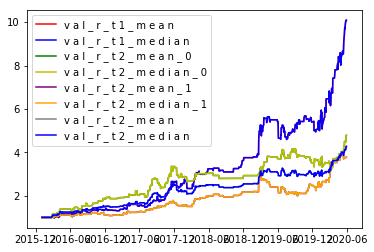


--------------------
M


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.046165,0.046165,0.032133,0.032133,0.022848,0.022848,0.026970,0.026970
median,0.018687,0.018687,0.008054,0.008054,0.014071,0.014071,0.013781,0.013781
std,0.098144,0.098144,0.083685,0.083685,0.074504,0.074504,0.064668,0.064668


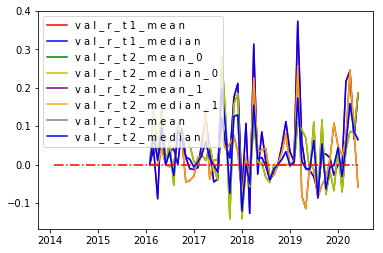


--------------------
Q


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,-0.001405,-0.001405,0.179666,0.179666,0.064206,0.064206,0.121936,0.121936


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.149748,0.149748,0.096454,0.096454,0.084866,0.084866,0.087621,0.087621
median,0.138183,0.138183,0.084670,0.084670,0.088082,0.088082,0.093376,0.093376
std,0.173889,0.173889,0.110150,0.110150,0.138368,0.138368,0.085556,0.085556


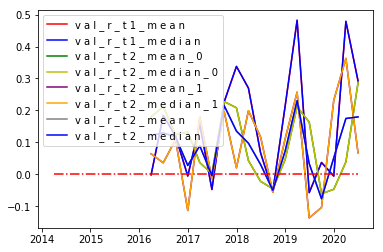


--------------------
A


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-31,0.334306,0.334306,0.865268,0.865268,0.084280,0.084280,0.474774,0.474774
2017-12-31,0.807422,0.807422,0.541047,0.541047,0.419806,0.419806,0.496478,0.496478
2018-12-31,0.556314,0.556314,0.018490,0.018490,0.403749,0.403749,0.152858,0.152858
2019-12-31,0.436327,0.436327,0.250662,0.250662,0.198814,0.198814,0.228643,0.228643
2020-12-31,0.911065,0.911065,0.336285,0.336285,0.454553,0.454553,0.385957,0.385957


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.609087,0.609087,0.402350,0.402350,0.312240,0.312240,0.347742,0.347742
median,0.556314,0.556314,0.336285,0.336285,0.403749,0.403749,0.385957,0.385957
std,0.244266,0.244266,0.319473,0.319473,0.162041,0.162041,0.151562,0.151562


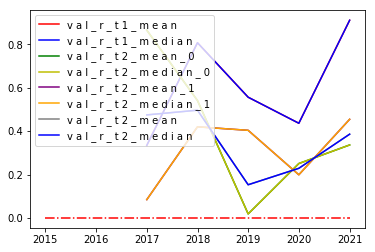

In [306]:
day_v = (day_r[['r_t1_mean','r_t1_median','r_t2_mean_0','r_t2_median_0','r_t2_mean_1','r_t2_median_1']]+1).cumprod().add_prefix('val_')
day_v.head()
day_v['val_r_t2_mean'] = (day_v['val_r_t2_mean_0']+day_v['val_r_t2_mean_1'])/2
day_v['val_r_t2_median'] = (day_v['val_r_t2_median_0']+day_v['val_r_t2_median_1'])/2
result_day = tmp_day.reindex(date).join(day_v,how='left')
result_day.head()
for col in day_v.columns:
    result_day['cummax_{}'.format(col)] = result_day[col].expanding().max() 
    result_day['withdraw_{}'.format(col)] = 1-result_day[col]/result_day['cummax_{}'.format(col)]
    plt.plot(result_day.index,result_day['withdraw_{}'.format(col)],color='r')
    plt.title('{} withdraw'.format(col))
    plt.show()

result_day.tail(20)


f= plt.figure()
for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
    _ = plt.plot(day_v.index,day_v[col],color=c,label=' '.join(col))
_ = plt.legend(loc='upper left')
plt.show()
# f.savefig('val_curve.png')



result_dict = {'day':result_day}

for key,p in zip(['month','quarter','year'],['M','Q','A']):
    result_period = result_day[day_v.columns].resample(p).apply(lambda x:x[-1]/x[0]-1)
    print('\n'+'-'*20+'\n'+p)
    result_dict[key] = result_period
    result_dict[key+'_stats'] = result_period.agg(['mean','median','std'])
    result_dict[key]
    result_dict[key+'_stats']
    
    for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
        _ = plt.plot(result_period.index,result_period[col],color=c,label=' '.join(col))
    _ = plt.legend(loc='upper left')
    _ = plt.plot(result_period.index,[0]*len(result_period),color='r',linestyle='-.')
    plt.show()

In [171]:
tmp_day.tail()

r_t1                     r_t2               
                mean    median size      mean    median size
date                                                        
2020-05-20 -0.002535 -0.002535    1 -0.027888 -0.027888    1
2020-05-21 -0.011274 -0.011274    1  0.018253  0.018253    1
2020-05-22  0.008744  0.008744    1  0.011243  0.011243    1
2020-05-25 -0.005199 -0.005199    1  0.021490  0.021490    1
2020-05-27  0.002269  0.002269    1  0.023071  0.023071    1